**Sungkyung Shon, Artificial Intelligence, Aston university, Birmingham, United Kingdom**

In [ ]:
!pip install boruta

In [4]:
import csv as csv 
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import datetime
import os
import warnings
import re
import altair as alt
import matplotlib.pyplot as plt                        # For plotting data
import seaborn as sns                                     # For plotting data

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier      #DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier   #RandomForestClassifier
from sklearn.metrics import roc_auc_score
from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler   #RandomUnderSampler
from sklearn.linear_model import LogisticRegression      #LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline     #pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GroupKFold  # For optimization
from pandas import DataFrame                       # For dataframes
from numpy import ravel                                  # For matrices
from sklearn.model_selection import train_test_split    # For train/test splits
from sklearn.neighbors import KNeighborsClassifier    # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline                                  # For setting up pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer, MaxAbsScaler, LabelEncoder# Various pre-processing steps
from sklearn.feature_selection import mutual_info_classif 
%matplotlib inline

warnings.filterwarnings("ignore")
from sklearn.model_selection import GroupShuffleSplit

In [5]:
# Load dataset
df = pd.read_csv('df_training_level3.csv')

In [6]:
df.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,NP_775663.1:2,11072,NP_775663.1,2,T,8725101,64601,9606,2,1,...,0.235874,-0.186116,-0.007055,0.227716,-1.469320,0.024950,0.054577,0.142123,0.194421,0.471760
1,NP_775663.1:2,11072,NP_775663.1,3,K,8725101,64601,9606,2,1,...,0.014759,-0.119949,-0.016030,0.040704,-1.614884,0.189634,-0.049600,0.005898,0.128652,0.254778
2,NP_775663.1:2,11072,NP_775663.1,4,K,8725101,64601,9606,2,1,...,0.066743,-0.165863,-0.061832,0.026400,-1.353973,0.140752,-0.168214,0.114217,-0.002818,0.247916
3,NP_775663.1:2,11072,NP_775663.1,5,P,8725101,64601,9606,2,1,...,-0.148641,-0.088860,-0.218482,0.103855,-1.252338,-0.000789,0.049453,0.197773,0.034994,0.303203
4,NP_775663.1:2,11072,NP_775663.1,6,G,8725101,64601,9606,2,1,...,0.251960,-0.122903,-0.191698,0.142125,-0.985092,0.029431,0.176924,0.302354,-0.138180,0.136602


In [7]:
# Remove the information columns and the 'Class' column
df_features = df.filter(regex='feat_esm1b_')
feature_columns = [col for col in df.columns if col.startswith('feat_esm1b_')]
filtered_df = df[feature_columns]
class_column = df['Class']
display(filtered_df.head())

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,0.115278,0.105343,0.256809,0.205551,-0.162306,-0.250113,-0.039983,-0.221369,0.016626,0.105289,...,0.235874,-0.186116,-0.007055,0.227716,-1.469320,0.024950,0.054577,0.142123,0.194421,0.471760
1,0.048915,-0.060122,0.054565,0.130224,-0.243280,0.032289,-0.035078,0.149056,-0.050518,-0.056080,...,0.014759,-0.119949,-0.016030,0.040704,-1.614884,0.189634,-0.049600,0.005898,0.128652,0.254778
2,0.029908,-0.069993,0.144604,0.031607,-0.157991,0.096214,-0.073147,0.150113,-0.123229,-0.060424,...,0.066743,-0.165863,-0.061832,0.026400,-1.353973,0.140752,-0.168214,0.114217,-0.002818,0.247916
3,-0.017817,0.063682,0.196507,0.219516,0.010169,0.048974,-0.102324,-0.071483,-0.063823,-0.034733,...,-0.148641,-0.088860,-0.218482,0.103855,-1.252338,-0.000789,0.049453,0.197773,0.034994,0.303203
4,0.183947,-0.002784,0.185983,0.299326,-0.256938,0.004182,-0.194807,-0.299934,-0.283545,-0.025699,...,0.251960,-0.122903,-0.191698,0.142125,-0.985092,0.029431,0.176924,0.302354,-0.138180,0.136602


In [8]:
#specify the number of entries, the number of non-null elements, and the kind of variable.
df.info()
#detect missing values
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Columns: 1294 entries, Info_PepID to feat_esm1b_1279
dtypes: float64(1280), int64(4), object(10)
memory usage: 717.4+ MB


feat_esm1b_633    1912
feat_esm1b_876    1912
feat_esm1b_854    1912
feat_esm1b_853    1912
feat_esm1b_852    1912
                  ... 
Info_type            0
Info_window          0
Info_cluster         0
Class                0
Info_PepID           0
Length: 1294, dtype: int64

**DataFrame information such as the number of items, the number of non-null components, and the type of variable in each column are provided. It also computes the percentage of each column and the number of missing values.**

In [9]:
# calculate the percentage of missing values, such that we can determine how to deal with variables having a high count
df.isnull().sum()/len(df)*100

Info_PepID          0.000000
Info_organism_id    0.000000
Info_protein_id     0.000000
Info_pos            0.000000
Info_AA             0.000000
                      ...   
feat_esm1b_1275     2.631325
feat_esm1b_1276     2.631325
feat_esm1b_1277     2.631325
feat_esm1b_1278     2.631325
feat_esm1b_1279     2.631325
Length: 1294, dtype: float64

In [ ]:
df.columns

In [10]:
pattern = re.compile(r'^Info.*')
matching_columns = [col for col in df.columns if pattern.match(col)]
print(matching_columns)

['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos', 'Info_AA', 'Info_pubmed_id', 'Info_epitope_id', 'Info_host_id', 'Info_nPos', 'Info_nNeg', 'Info_type', 'Info_window', 'Info_cluster']


In [11]:
columns_to_drop = ['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos', 'Info_AA', 'Info_pubmed_id', 'Info_epitope_id', 'Info_host_id', 'Info_nPos', 'Info_nNeg', 'Info_type', 'Info_window']

# Drop the specified columns
df = df.drop(columns_to_drop,axis=1)
df

,Info_cluster,Class,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,8,1,0.115278,0.105343,0.256809,0.205551,-0.162306,-0.250113,-0.039983,-0.221369,...,0.235874,-0.186116,-0.007055,0.227716,-1.469320,0.024950,0.054577,0.142123,0.194421,0.471760
1,8,1,0.048915,-0.060122,0.054565,0.130224,-0.243280,0.032289,-0.035078,0.149056,...,0.014759,-0.119949,-0.016030,0.040704,-1.614884,0.189634,-0.049600,0.005898,0.128652,0.254778
2,8,1,0.029908,-0.069993,0.144604,0.031607,-0.157991,0.096214,-0.073147,0.150113,...,0.066743,-0.165863,-0.061832,0.026400,-1.353973,0.140752,-0.168214,0.114217,-0.002818,0.247916
3,8,1,-0.017817,0.063682,0.196507,0.219516,0.010169,0.048974,-0.102324,-0.071483,...,-0.148641,-0.088860,-0.218482,0.103855,-1.252338,-0.000789,0.049453,0.197773,0.034994,0.303203
4,8,1,0.183947,-0.002784,0.185983,0.299326,-0.256938,0.004182,-0.194807,-0.299934,...,0.251960,-0.122903,-0.191698,0.142125,-0.985092,0.029431,0.176924,0.302354,-0.138180,0.136602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72658,8,1,-0.060893,0.387238,0.030345,0.005711,-0.147543,0.013120,-0.260891,0.104144,...,0.289453,-0.096301,0.030024,0.195304,-0.801965,-0.274976,0.178286,0.165846,0.177845,0.332194
72659,8,1,0.199185,0.368873,0.180725,0.057800,-0.017099,-0.028999,-0.153706,-0.175476,...,0.250574,-0.246241,0.077579,-0.052833,-0.979619,-0.031028,0.186897,0.133366,0.157032,0.341441
72660,8,1,-0.180276,0.448252,-0.102101,0.106668,-0.206699,-0.118161,0.044999,-0.046077,...,0.170998,-0.051927,-0.083331,0.035247,-1.028582,-0.234735,-0.006005,0.206064,0.058616,0.237192
72661,8,1,-0.274478,0.362613,0.431246,0.164276,-0.130307,-0.204145,0.203404,-0.083181,...,0.148796,-0.283643,0.028591,0.037022,-1.073474,-0.182251,0.221717,0.074508,0.227138,0.319858


In [ ]:
df.head()

In [12]:
# Split dataset into training, validation, and test sets
train_inds, val_inds, test_inds = [], [], []
group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_inds, test_inds in group_splitter.split(df, groups=df['Info_cluster']):
    train_inds, val_inds = next(GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42).split(df.iloc[train_val_inds], groups=df.iloc[train_val_inds]['Info_cluster']))
    
train_df = df.iloc[train_inds]
val_df = df.iloc[val_inds]
test_df = df.iloc[test_inds]

In [13]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(2574, 1282)
(22939, 1282)
(47150, 1282)


In [14]:
# Check class balance
class_counts = train_df['Class'].value_counts()
print('Class counts:', class_counts)

Class counts: -1    2000
 1     574
Name: Class, dtype: int64


In [15]:
# Explore the dataset
df.head()
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Columns: 1282 entries, Info_cluster to feat_esm1b_1279
dtypes: float64(1280), int64(2)
memory usage: 710.7 MB


<Axes: xlabel='Class', ylabel='count'>

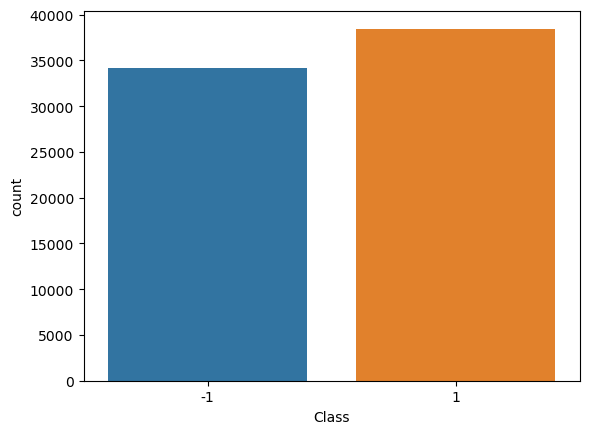

In [16]:
# Visualize class balance
sns.countplot(x='Class', data=df)

In [17]:
# Investigate missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

feat_esm1b_0       1912
feat_esm1b_1       1912
feat_esm1b_2       1912
feat_esm1b_3       1912
feat_esm1b_4       1912
                   ... 
feat_esm1b_1275    1912
feat_esm1b_1276    1912
feat_esm1b_1277    1912
feat_esm1b_1278    1912
feat_esm1b_1279    1912
Length: 1280, dtype: int64


In [ ]:
# Investigate correlations between features
# corr_matrix = df.drop(columns=['Info_cluster', 'Class']).corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)

In [18]:
missing_values = df.isnull().sum()
print(missing_values)

Info_cluster          0
Class                 0
feat_esm1b_0       1912
feat_esm1b_1       1912
feat_esm1b_2       1912
                   ... 
feat_esm1b_1275    1912
feat_esm1b_1276    1912
feat_esm1b_1277    1912
feat_esm1b_1278    1912
feat_esm1b_1279    1912
Length: 1282, dtype: int64


In [19]:
# Drop rows containing missing values
df_no_missing = df.dropna(inplace=True)
print(df_no_missing)

None


In [20]:
duplicates = df.duplicated()
print(duplicates)

0        False
1        False
2        False
3        False
4        False
         ...  
72658    False
72659    False
72660    False
72661    False
72662    False
Length: 70751, dtype: bool


In [21]:
# Calculate skewness of each numerical feature
skewness = df.skew()
print(skewness)

Info_cluster       7.327364
Class             -0.151986
feat_esm1b_0      -0.387981
feat_esm1b_1       0.193781
feat_esm1b_2       0.090272
                     ...   
feat_esm1b_1275    0.903363
feat_esm1b_1276    0.469093
feat_esm1b_1277   -0.866875
feat_esm1b_1278   -0.667644
feat_esm1b_1279   -1.329682
Length: 1282, dtype: float64


In [22]:
# Select features with high skewness values (|skewness| > 1)
high_skewness = skewness[abs(skewness) > 1]
print(high_skewness)

Info_cluster       7.327364
feat_esm1b_61     -1.124499
feat_esm1b_98     -1.131143
feat_esm1b_131     1.176991
feat_esm1b_149     1.021266
feat_esm1b_159    -1.005051
feat_esm1b_304     1.134366
feat_esm1b_313    -1.153485
feat_esm1b_330    -1.178132
feat_esm1b_358     1.173644
feat_esm1b_425    -1.051719
feat_esm1b_438     1.348175
feat_esm1b_450     2.052672
feat_esm1b_478     1.031640
feat_esm1b_518    -1.259561
feat_esm1b_627     1.162392
feat_esm1b_697    -1.001831
feat_esm1b_715     1.029762
feat_esm1b_767     1.047922
feat_esm1b_769    -1.611065
feat_esm1b_802    -1.030325
feat_esm1b_864     1.115707
feat_esm1b_885     1.180971
feat_esm1b_908    -1.505715
feat_esm1b_946    -1.362466
feat_esm1b_947     1.053892
feat_esm1b_1006   -1.106576
feat_esm1b_1013   -1.613632
feat_esm1b_1014    1.151940
feat_esm1b_1023    1.118887
feat_esm1b_1075   -1.045540
feat_esm1b_1097    1.059778
feat_esm1b_1127   -1.006476
feat_esm1b_1161    1.109660
feat_esm1b_1213   -1.318487
feat_esm1b_1249   -1

In [ ]:
# Apply t-SNE to the data
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df)

In [ ]:
# Plot the t-SNE results
plt.figure(figsize=(12, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.show()

In [ ]:
# Apply t-SNE to the data
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(train_df)
# Plot the t-SNE results
plt.figure(figsize=(12, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.show()

In [ ]:
# Apply t-SNE to the data
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(val_df)
# Plot the t-SNE results
plt.figure(figsize=(12, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.show()

In [23]:
# Calculate descriptive statistics
stats = df.describe()
print(stats)
max_values = df.max()
min_values = df.min()

       Info_cluster         Class  feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  \
count  70751.000000  70751.000000  70751.000000  70751.000000  70751.000000   
mean      20.216633      0.075773      0.024815      0.173018      0.113880   
std       35.135080      0.997132      0.174920      0.176281      0.181818   
min        8.000000     -1.000000     -0.971916     -0.904106     -0.910500   
25%        8.000000     -1.000000     -0.081343      0.067374     -0.005635   
50%        8.000000      1.000000      0.034574      0.172033      0.110035   
75%       28.000000      1.000000      0.141719      0.273446      0.229405   
max      587.000000      1.000000      0.933674      1.169529      1.206786   

       feat_esm1b_3  feat_esm1b_4  feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  \
count  70751.000000  70751.000000  70751.000000  70751.000000  70751.000000   
mean       0.027288     -0.082433     -0.123585     -0.105387     -0.034119   
std        0.158430      0.160356      0.186805    

In [ ]:
# Create a line chart to display max and min values
fig, ax = plt.subplots()
ax.plot(max_values.values, label='Max')
ax.plot(min_values.values, label='Min')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Value')
ax.legend()
plt.show()

In [ ]:
# Calculate the range (max - min) for each numerical feature
ranges = df.max() - df.min()
print(ranges)

In [24]:
# Group by Info_cluster and get value counts of the target class within each group
class_balance = df.groupby('Info_cluster')['Class'].value_counts()
class_balance

Info_cluster  Class
8              1       28233
              -1       17738
28            -1       11199
               1        8150
34            -1        1083
               1          62
35            -1        1513
               1         110
36            -1         183
               1          61
44            -1          27
50             1          87
62             1         338
              -1         186
150           -1         283
               1         281
198            1          31
              -1          12
199            1          30
204           -1         289
               1         227
206            1          20
215            1          20
219            1          38
222            1          15
225           -1         182
               1          58
229            1          54
232            1          45
256            1           7
264            1           8
298            1          69
320            1          42
489            1       

In [73]:
cluster_counts = df['Info_cluster'].value_counts()
total_examples = len(df)

split1_examples = round(total_examples * 0.65)  # Training Data
split2_examples = round(total_examples * 0.25)  # Validation Data
split3_examples = round(total_examples * 0.1)  # Testing Data

In [74]:
cluster_allocations = {}
for i, count in cluster_counts.items():
    if split1_examples >= count:
        cluster_allocations[i] = 1
        split1_examples -= count
    elif split2_examples >= count:
        cluster_allocations[i] = 2
        split2_examples -= count
    else:
        cluster_allocations[i] = 3
        split3_examples -= count

In [75]:
train_df = pd.DataFrame()# Training Data
val_df = pd.DataFrame()# Validation Data
test_df = pd.DataFrame()# Testing Data

for i, allocation in cluster_allocations.items():
    current_rows = df[df['Info_cluster'] == i]
    
    if allocation == 1:
        train_df = train_df.append(current_rows, ignore_index=True)
    elif allocation == 2:
        val_df = val_df.append(current_rows, ignore_index=True)
    else:
        test_df = test_df.append(current_rows, ignore_index=True)
    
    print(f"Info Cluster {i} allocated to split {allocation}")

Info Cluster 8 allocated to split 1
Info Cluster 28 allocated to split 3
Info Cluster 35 allocated to split 2
Info Cluster 34 allocated to split 2
Info Cluster 150 allocated to split 2
Info Cluster 62 allocated to split 2
Info Cluster 204 allocated to split 2
Info Cluster 36 allocated to split 2
Info Cluster 225 allocated to split 2
Info Cluster 50 allocated to split 2
Info Cluster 298 allocated to split 2
Info Cluster 229 allocated to split 2
Info Cluster 587 allocated to split 2
Info Cluster 232 allocated to split 2
Info Cluster 198 allocated to split 2
Info Cluster 320 allocated to split 2
Info Cluster 219 allocated to split 2
Info Cluster 199 allocated to split 2
Info Cluster 44 allocated to split 2
Info Cluster 215 allocated to split 2
Info Cluster 489 allocated to split 2
Info Cluster 206 allocated to split 2
Info Cluster 222 allocated to split 1
Info Cluster 264 allocated to split 2
Info Cluster 256 allocated to split 2


In [95]:
train_df = pd.DataFrame()# Training Data
val_df = pd.DataFrame()# Validation Data
test_df = pd.DataFrame()# Testing Data

In [96]:
train_df = pd.concat([df[df['Info_cluster'] == 8],df[df['Info_cluster'] == 50],df[df['Info_cluster'] == 199],df[df['Info_cluster'] == 206],df[df['Info_cluster'] == 150],df[df['Info_cluster'] == 222],df[df['Info_cluster'] == 232],df[df['Info_cluster'] == 198]], axis=0)
val_df= pd.concat([df[df['Info_cluster'] == 28],df[df['Info_cluster'] == 36],df[df['Info_cluster'] == 62],df[df['Info_cluster'] == 219],df[df['Info_cluster'] == 298],df[df['Info_cluster'] == 204],df[df['Info_cluster'] == 215],df[df['Info_cluster'] == 229],df[df['Info_cluster'] == 256]], axis=0)
test_df = pd.concat([df[df['Info_cluster'] == 34],df[df['Info_cluster'] == 35],df[df['Info_cluster'] == 44],df[df['Info_cluster'] == 225],df[df['Info_cluster'] == 264],df[df['Info_cluster'] == 320],df[df['Info_cluster'] == 489],df[df['Info_cluster'] == 587]], axis=0)

In [97]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)

In [98]:
y_test=test_df['Class']
X_test=test_df.drop('Class',axis=1)

In [99]:
y_val=val_df['Class']

In [100]:
y_val=val_df['Class']
X_val=val_df.drop('Class',axis=1)

In [43]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

In [44]:
normalized_train_df = scaler.fit_transform(train_df)

In [46]:
train_df_copy = train_df.copy()
print(train_df_copy.head())

   Info_cluster  Class  feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  \
0             8      1      0.115278      0.105343      0.256809   
1             8      1      0.048915     -0.060122      0.054565   
2             8      1      0.029908     -0.069993      0.144604   
3             8      1     -0.017817      0.063682      0.196507   
4             8      1      0.183947     -0.002784      0.185983   

   feat_esm1b_3  feat_esm1b_4  feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  ...  \
0      0.205551     -0.162306     -0.250113     -0.039983     -0.221369  ...   
1      0.130224     -0.243280      0.032289     -0.035078      0.149056  ...   
2      0.031607     -0.157991      0.096214     -0.073147      0.150113  ...   
3      0.219516      0.010169      0.048974     -0.102324     -0.071483  ...   
4      0.299326     -0.256938      0.004182     -0.194807     -0.299934  ...   

   feat_esm1b_1270  feat_esm1b_1271  feat_esm1b_1272  feat_esm1b_1273  \
0         0.235874        -0.186116  

In [47]:
# Assuming df is an existing DataFrame and 'column_to_delete' is the column name you want to remove
train_df_copy = train_df_copy.drop(columns=['Info_cluster'])
print(train_df_copy.head())

   Class  feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  feat_esm1b_3  \
0      1      0.115278      0.105343      0.256809      0.205551   
1      1      0.048915     -0.060122      0.054565      0.130224   
2      1      0.029908     -0.069993      0.144604      0.031607   
3      1     -0.017817      0.063682      0.196507      0.219516   
4      1      0.183947     -0.002784      0.185983      0.299326   

   feat_esm1b_4  feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  feat_esm1b_8  ...  \
0     -0.162306     -0.250113     -0.039983     -0.221369      0.016626  ...   
1     -0.243280      0.032289     -0.035078      0.149056     -0.050518  ...   
2     -0.157991      0.096214     -0.073147      0.150113     -0.123229  ...   
3      0.010169      0.048974     -0.102324     -0.071483     -0.063823  ...   
4     -0.256938      0.004182     -0.194807     -0.299934     -0.283545  ...   

   feat_esm1b_1270  feat_esm1b_1271  feat_esm1b_1272  feat_esm1b_1273  \
0         0.235874        -0.186116  

In [48]:
# Fit the scaler to the feature data and transform it
scaled_train_df = scaler.fit_transform(train_df_copy)
scaled_train_df

array([[1.        , 0.53020521, 0.49373589, ..., 0.68967706, 0.62108709,
        0.83804747],
       [1.        , 0.49210988, 0.39370091, ..., 0.61151082, 0.58541704,
        0.74442669],
       [1.        , 0.48119878, 0.38773367, ..., 0.67366456, 0.51411463,
        0.74146599],
       ...,
       [1.        , 0.46496914, 0.62707806, ..., 0.68028412, 0.48204446,
        0.85008128],
       [1.        , 0.49025636, 0.61818011, ..., 0.56792053, 0.52390606,
        0.92540127],
       [1.        , 0.55910112, 0.50527874, ..., 0.60613523, 0.5247293 ,
        0.93410507]])

In [49]:
dataframe_train_df_data_scaled = pd.DataFrame(scaled_train_df,columns=train_df_copy.columns)
train_df.update(dataframe_train_df_data_scaled)

In [50]:
print(train_df)

       Info_cluster  Class  feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  \
0                 8    1.0      0.530205      0.493736      0.642420   
1                 8    1.0      0.492110      0.393701      0.531116   
2                 8    1.0      0.481199      0.387734      0.580669   
3                 8    1.0      0.453802      0.468549      0.609233   
4                 8    1.0      0.569624      0.428366      0.603441   
...             ...    ...           ...           ...           ...   
45981           222    1.0      0.416722      0.629192      0.685242   
45982           222    1.0      0.513677      0.615744      0.620637   
45983           222    1.0      0.464969      0.627078      0.652500   
45984           222    1.0      0.490256      0.618180      0.556202   
45985           222    1.0      0.559101      0.505279      0.795913   

       feat_esm1b_3  feat_esm1b_4  feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  \
0          0.622160      0.443734      0.384668      0.5

In [51]:
# Calculate skewness of each numerical feature
skewness = train_df.skew()
print(skewness)

Info_cluster       55.343775
Class              -0.469538
feat_esm1b_0       -0.357041
feat_esm1b_1       -0.011433
feat_esm1b_2        0.074060
                     ...    
feat_esm1b_1275     1.067669
feat_esm1b_1276     0.575964
feat_esm1b_1277    -0.835359
feat_esm1b_1278    -0.633288
feat_esm1b_1279    -1.287429
Length: 1282, dtype: float64


In [52]:
# Select features with high skewness values (e.g., |skewness| > 1)
high_skewness = skewness[abs(skewness) > 1]
print(high_skewness)

Info_cluster       55.343775
feat_esm1b_61      -1.050133
feat_esm1b_98      -1.097542
feat_esm1b_131      1.081922
feat_esm1b_149      1.055121
feat_esm1b_159     -1.015260
feat_esm1b_241     -1.148836
feat_esm1b_244      1.122161
feat_esm1b_304      1.127208
feat_esm1b_313     -1.183204
feat_esm1b_330     -1.098307
feat_esm1b_358      1.101140
feat_esm1b_425     -1.040371
feat_esm1b_438      1.296835
feat_esm1b_450      1.830629
feat_esm1b_518     -1.171201
feat_esm1b_629      1.012841
feat_esm1b_682     -1.103162
feat_esm1b_769     -1.593929
feat_esm1b_777     -1.070246
feat_esm1b_847      1.034925
feat_esm1b_852      1.062366
feat_esm1b_864      1.212421
feat_esm1b_885      1.100630
feat_esm1b_908     -1.366974
feat_esm1b_946     -1.315168
feat_esm1b_947      1.009481
feat_esm1b_1006    -1.027390
feat_esm1b_1013    -1.572593
feat_esm1b_1014     1.057464
feat_esm1b_1053    -1.038167
feat_esm1b_1097     1.056711
feat_esm1b_1104    -1.001034
feat_esm1b_1161     1.039306
feat_esm1b_120

In [54]:
# Plot the skewness
plt.figure(figsize=(12, 10))
skewness.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel("Skewness")
plt.show()

In [56]:
importances = mutual_info_classif(X_train, y_train)

In [57]:
feat_importances=pd.Series(importances,X_train.columns[0:len(X_train.columns)])

In [ ]:
feat_importances.plot(kind='barh',color='teal')
plt.show()

In [58]:
# create a PCA object with desired number of components
pca = PCA(n_components=2)

# fit PCA on the training data
pca.fit(train_df)

# transform the data into principal components
train_df_pca = pca.transform(train_df)
test__df_pca = pca.transform(test_df)

In [59]:
# Instantiate PCA with n_components=0.95
pca = PCA(n_components=0.95)

# Fit and transform the training data
train_df_pca = pca.fit_transform(train_df)

# Transform the tuning and validation data
test_df_pca = pca.transform(val_df)
val_df_pca = pca.transform(test_df)

# Print the number of principal components selected
print(f"Number of principal components selected: {pca.n_components_}")

Number of principal components selected: 381


In [60]:
# Instantiate a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')

# Instantiate Boruta feature selection
boruta_feature_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=42)

In [101]:
cluster_counts = train_df['Info_cluster'].value_counts()
total_examples = len(train_df)

split1_examples = round(total_examples * 0.6)  # Training Data
split2_examples = round(total_examples * 0.4)  # Testing Data

cluster_allocations = {}
for i, count in cluster_counts.items():
    if split1_examples >= count:
        cluster_allocations[i] = 1
        split1_examples -= count
    else:
        cluster_allocations[i] = 2
        split2_examples -= count

train_df = pd.DataFrame()# Training Data
test_df = pd.DataFrame()# Testing Data

for i, allocation in cluster_allocations.items():
    current_rows = df[df['Info_cluster'] == i]
    
    if allocation == 1:
        train_df = train_df.append(current_rows, ignore_index=True)
    else:
        test_df = test_df.append(current_rows, ignore_index=True)
    
    print(f"Info Cluster {i} allocated to split {allocation}")

Info Cluster 8 allocated to split 2
Info Cluster 150 allocated to split 1
Info Cluster 50 allocated to split 1
Info Cluster 232 allocated to split 1
Info Cluster 198 allocated to split 1
Info Cluster 199 allocated to split 1
Info Cluster 206 allocated to split 1
Info Cluster 222 allocated to split 1


In [84]:
train_df

,Info_cluster,Class,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,222,1,-0.227523,0.132470,0.158933,0.307387,-0.246765,-0.027730,0.201507,-0.143304,...,0.144026,-0.158679,-0.116429,-0.006377,-0.841997,-0.139761,-0.044355,-0.083693,0.166240,0.340400
1,222,1,-0.041850,0.206315,-0.159114,0.263294,-0.035497,-0.248510,0.185663,0.199593,...,0.210462,0.109581,0.068168,0.109193,-0.982957,-0.017489,-0.221715,0.163561,-0.195525,0.571705
2,222,1,-0.155975,0.303151,-0.057432,0.142286,0.142568,-0.223679,0.141198,-0.044333,...,-0.027750,-0.065439,0.024224,0.047982,-0.790832,-0.029045,-0.188507,0.095620,0.004118,0.479970
3,222,1,0.056185,0.058463,0.244521,0.278990,-0.225740,-0.275116,0.246452,0.014478,...,0.128096,-0.136811,0.153944,-0.092948,-1.262759,-0.117635,-0.268348,0.243232,-0.181503,0.338583
4,222,1,-0.028689,0.254117,0.270150,0.011365,-0.188427,-0.272291,0.198643,-0.138021,...,0.118605,-0.164579,0.116733,0.076382,-0.798824,-0.092633,-0.241037,0.072947,0.128304,0.804927
5,222,1,0.029645,0.207810,0.159380,-0.034593,-0.236920,-0.211259,-0.061983,-0.153272,...,0.099327,0.058176,0.057389,-0.033304,-1.140336,-0.253039,-0.112142,-0.116256,-0.040661,0.665855
6,222,1,-0.123478,0.280116,-0.061716,0.188484,-0.082860,-0.314645,0.049608,0.174779,...,0.255017,0.006374,0.008892,0.169319,-1.094136,-0.045143,-0.263671,0.174941,-0.081687,0.615816
7,222,1,-0.225383,0.200990,0.234572,0.248151,-0.187474,-0.211690,0.249663,-0.046652,...,0.195083,-0.165389,-0.124347,-0.111438,-1.131672,0.072224,-0.009375,0.248948,0.031562,0.466665
8,222,1,0.037882,0.369890,0.320213,-0.012237,0.003041,-0.058281,-0.071040,0.012355,...,0.029288,-0.086442,-0.179355,-0.131625,-0.836974,0.017848,-0.110607,0.250130,-0.108336,0.601740
9,222,1,-0.012345,0.179917,0.032676,0.179754,-0.049852,-0.008164,0.024345,-0.346140,...,0.323702,-0.111826,-0.228313,0.008738,-0.847412,0.120851,-0.344837,0.144155,0.079321,0.477577


In [103]:
newdf = train_df.copy()

In [104]:
# Separate the feature and target columns
y_train = train_df['Class']
X_train = newdf.drop(['Class'], axis=1)

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42)

# Resample the training data to balance the classes
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Check the class balance after resampling
print('Class counts after resampling:', y_train_res.value_counts())

Class counts after resampling: -1    295
 1    295
Name: Class, dtype: int64


In [ ]:
X_train

In [105]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a classifier on the balanced dataset
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_smote, y_train_smote)

# Predict and evaluate the classifier's performance
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.37      0.00      0.01      2805
           1       0.11      0.95      0.19       350

    accuracy                           0.11      3155
   macro avg       0.24      0.48      0.10      3155
weighted avg       0.34      0.11      0.03      3155



In [106]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a classifier on the balanced dataset
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_smote, y_train_smote)

# Predict and evaluate the classifier's performance
y_pred = classifier.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.08      0.14     11857
           1       0.44      0.94      0.60      8964

    accuracy                           0.45     20821
   macro avg       0.54      0.51      0.37     20821
weighted avg       0.55      0.45      0.34     20821



In [107]:
# Define the SMOTE object
smote = SMOTE(random_state=42)

# Define the logistic regression object
log_reg = LogisticRegression(random_state=42)

# Define the hyperparameter search space
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 500, 1000],
              'class_weight': ['balanced', None]}

# Define the scoring metric
scoring = make_scorer(f1_score)

In [108]:
group=np.array(X_val['Info_cluster'])
model = LogisticRegression()

# Define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Define group k-fold cross-validator
gkf = GroupKFold(n_splits=5)

# Define search 
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=gkf)

# Fit the model
result = search.fit(X_val, y_val, groups=group)

# Calculate probabilities for the positive class
y_proba = search.predict_proba(X_val)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_val, y_proba)
print('ROC AUC Score:', roc_auc)

# Print best score and hyperparameters
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

BestScore_LogisticRegression = result.best_score_
BestHyperParameters_LogisticRegression = result.best_params_

ROC AUC Score: 0.859080691305136
Best Score: 0.5843625359035267
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [109]:
model = DecisionTreeClassifier()

# Define search space
space = dict()
space['criterion'] = ['gini', 'entropy']
space['splitter'] = ['best', 'random']
space['max_depth'] = [None, 1, 2, 4, 6, 8, 10]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]

# Define group k-fold cross-validator
gkf = GroupKFold(n_splits=5)

# Define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=gkf)

# Fit the model
result = search.fit(X_val, y_val, groups=group)

# Calculate probabilities for the positive class
y_proba = search.predict_proba(X_val)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_val, y_proba)
print('ROC AUC Score:', roc_auc)

# Print best score and hyperparameters
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

BestScore_DecisionTree = result.best_score_
BestHyperParameters_DecisionTree = result.best_params_

ROC AUC Score: 0.5871334051921799
Best Score: 0.5729648872299978
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}


In [ ]:
model = RandomForestClassifier()

# Define search space
space = dict()
space['n_estimators'] = [10, 50, 100, 200]
space['criterion'] = ['gini', 'entropy']
space['max_depth'] = [None, 1, 2, 4, 6, 8, 10]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]

# Define group k-fold cross-validator
gkf = GroupKFold(n_splits=5)

# Define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=gkf)

# Fit the model
result = search.fit(X_val, y_val, groups=group)

# Calculate probabilities for the positive class
y_proba = search.predict_proba(X_val)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_val, y_proba)
print('ROC AUC Score:', roc_auc)

# Print best score and hyperparameters
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

BestScore_RandomForest = result.best_score_
BestHyperParameters_RandomForest = result.best_params_

In [ ]:
pipe=Pipeline([
('scaler', StandardScaler()), ('selector',SelectKBest(score_func=mutual_info_classif)),
('classifier', RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=20, bootstrap=True, class_weight='balanced', random_state=42))
])
#Fit the pipeline to the training data
result=pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

accuracy=accuracy_score(y_test,y_pred)
print('AUC-ROC score :',roc_auc_score(y_test,y_pred))